MEM T380

Case Studies Group 10

Ante Sokosa  
Ziad Hatab

Final Project - Weld Defect Classification with Aritifial Neural Networks

The 2019 Research Paper in the Journal of Intelligent Manufacturing from Lu Yang and Hongquan Jiang titled "Weld defect classifcation in radiographic images using unifed deep
neural network with multi‑level features" was used as the basis for this project. The paper can be found here: https://doi.org/10.1007/s10845-020-01581-2.

The researchers used a set of radiographic weld defect images to train a Deep Neural Network to classify them. This is an important task to improve efficiency and accuracy of quality assurance in automated manufacturing.

We have attemped to replicate their classification model to the greatest degree possible with the information available in the paper and have used the same dataset for our training, testing, and validaiton.

# 0 &nbsp; `Imports and Setup`

In [14]:
# for calculating notebook runtime
import time
start_time = time.time()

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable gpu visability and use cpu instead to keep tensorflow results as consistent as possible

In [16]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import random

# set random seeds to ensure reproducibility of results as best as possible
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

from keras.models import Sequential, Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, concatenate
from keras.wrappers.scikit_learn import KerasClassifier

from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

# 1 &nbsp; `Data Exploration`

From the radiographic images of weld defects, features were extracted. The defects and features can be seen below for reference. This part of of the paper was not replicated. It is outside the scope of DNNs and we have begun with their feature set.

`Defect Types:`  
- `PO` = porosity
- `SL` = slag inclusion
- `LP` = lack of penetration
- `LF` = lack of fusion
- `CR` = crack

`Defect Features:`

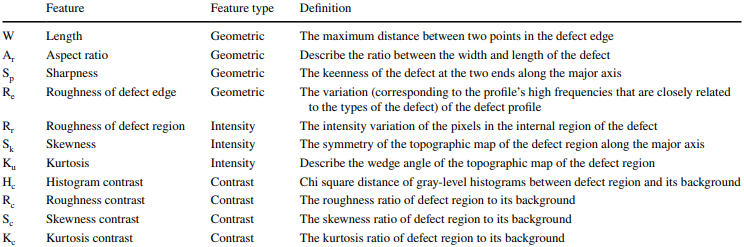 [1]




The researchers split their 220 data points into 5 balanced subsets. From one subset to another, amount of each defect type remained equal. These subsets were used for 5-fold cross validation. We have done the same but also concatednated the data and re-split them for our own cross validation.

The code block below:
- loads the data from an excel file
- renames the columns for ease of use 
- removes the one duplicate row and resets the index
- concatenates the sheets/subsets 
- preps the features data for the DNN via standardization
- preps the target data for the DNN via one-hot encoding
- saves a cleaned excel file for future use

In [17]:
excel_file = 'weld_defect_dataset.xlsx'

# gather data from excel file
subsets = []
for i in range(1, 6):
    subset = pd.read_excel(excel_file, sheet_name = 'subset' + str(i))
    subset = subset.rename(columns={'Type':'type','W':'w','Ar':'ar','Sp':'sp','Re':'re','Rr':'rr','Sk':'sk','Ku':'ku','Hc':'hc','Rc':'rc','Sc ':'sc','Kc ':'kc'}) # note the space after Sc and Kc are errors in naming in the excel file and are corrected here for ease of use later
    subsets.append(subset)
df = pd.concat(subsets, ignore_index=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Features
nums = list(df.select_dtypes(include=['float64']).columns)
df[nums] = StandardScaler().fit_transform(df[nums])

# Target
types = df['type'].unique().tolist()
print('types:',types)
cat_type = CategoricalDtype(categories=types, ordered=True) # specify the order of categories (stop it from going in alphabetical order; good for confusion matricies comparisons to paper later)
df['type'] = df['type'].astype(cat_type) # convert column to categorical type
df['type_copy'] = df['type'] # create column for get_dummies() to work on so that we keep the orignal 'type' columns afterwards
df = pd.get_dummies(df, columns=['type_copy'], prefix=['type']) # get dummies

excel_file_clean = excel_file.split('.')[0]+'_clean.xlsx'
df.to_excel(excel_file_clean, index=False)
df # clean and prepped dataframe

types: ['PO', 'SL', 'LP', 'LF', 'CR']


,type,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc,type_PO,type_SL,type_LP,type_LF,type_CR
0,PO,-0.874553,-0.786637,-0.116198,1.687500,3.592437,-0.462970,2.014749,-0.646807,-0.608549,0.112723,-0.587744,1,0,0,0,0
1,PO,-0.867095,-0.800094,-0.873054,1.687500,1.916513,-0.783785,-0.847640,-0.649219,-0.550744,0.643202,-0.230305,1,0,0,0,0
2,PO,-0.882011,-0.800094,-0.739818,2.324728,2.420339,-0.729491,1.073546,-0.650634,-0.513391,0.576477,-0.225458,1,0,0,0,0
3,PO,-0.770168,-0.800094,-1.330129,0.540485,-0.903687,0.469655,1.223842,-0.597296,-0.716502,-0.141997,-0.921506,1,0,0,0,0
4,PO,-0.822358,-0.800094,-0.913765,0.625398,-1.020156,2.505449,0.173118,-0.620766,-0.824734,0.211772,-1.363982,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,CR,0.527210,2.890215,1.974872,-1.089548,2.270158,-0.870020,-0.899740,0.061944,3.128958,-0.064287,0.250808,0,0,0,0,1
215,CR,-0.143847,1.998389,1.005208,-1.268292,1.245591,-0.196870,-0.352191,-0.590920,0.263546,1.189902,0.347742,0,0,0,0,1
216,CR,0.750896,2.488716,0.509273,-1.074733,0.758081,-0.854702,-0.771054,0.713970,3.128171,-0.574069,0.534778,0,0,0,0,1
217,CR,0.758354,1.443158,0.194687,-0.935655,0.645220,-0.780371,-0.740219,0.449058,2.452631,-0.154380,0.593998,0,0,0,0,1


Using `.info()` and `.describe()` for data confirmation and reference:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   type     219 non-null    category
 1   w        219 non-null    float64 
 2   ar       219 non-null    float64 
 3   sp       219 non-null    float64 
 4   re       219 non-null    float64 
 5   rr       219 non-null    float64 
 6   sk       219 non-null    float64 
 7   ku       219 non-null    float64 
 8   hc       219 non-null    float64 
 9   rc       219 non-null    float64 
 10  sc       219 non-null    float64 
 11  kc       219 non-null    float64 
 12  type_PO  219 non-null    uint8   
 13  type_SL  219 non-null    uint8   
 14  type_LP  219 non-null    uint8   
 15  type_LF  219 non-null    uint8   
 16  type_CR  219 non-null    uint8   
dtypes: category(1), float64(11), uint8(5)
memory usage: 20.4 KB


In [19]:
df[nums].describe()

,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc
count,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02
mean,-8.111218e-18,-3.244487e-17,1.662800e-16,-9.733462e-17,-6.083414e-18,-7.502877e-17,1.022014e-15,3.244487e-17,-4.461170e-17,9.125121e-17,-4.866731e-17
std,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00
min,-9.118320e-01,-8.000944e-01,-2.658791e+00,-1.475707e+00,-1.198802e+00,-1.012763e+00,-2.886221e+00,-6.694647e-01,-1.228245e+00,-1.672119e+00,-2.987224e+00
25%,-7.254280e-01,-7.653339e-01,-8.526988e-01,-9.823347e-01,-7.802472e-01,-6.275409e-01,-5.615597e-01,-5.772531e-01,-6.256668e-01,-6.639940e-01,-7.075824e-01
50%,-5.091975e-01,-5.683864e-01,-5.883228e-02,6.654728e-02,-1.722487e-01,-3.363570e-01,-2.232333e-01,-4.229268e-01,-3.357616e-01,-1.781106e-01,2.536041e-02
75%,5.272102e-01,6.058740e-01,1.049620e+00,7.977667e-01,4.401597e-01,1.959837e-01,4.299905e-01,1.516094e-01,2.171876e-01,5.471275e-01,6.215435e-01
max,4.285127e+00,3.236178e+00,1.974872e+00,2.324728e+00,3.618412e+00,5.087585e+00,3.966286e+00,6.907185e+00,4.537491e+00,5.315733e+00,3.629988e+00


We can also visualize the feature data in a pairplot and heatmap. We see decent clustering in the pairplot and correlation in the heatmap. Our model should be able to do well with this data.

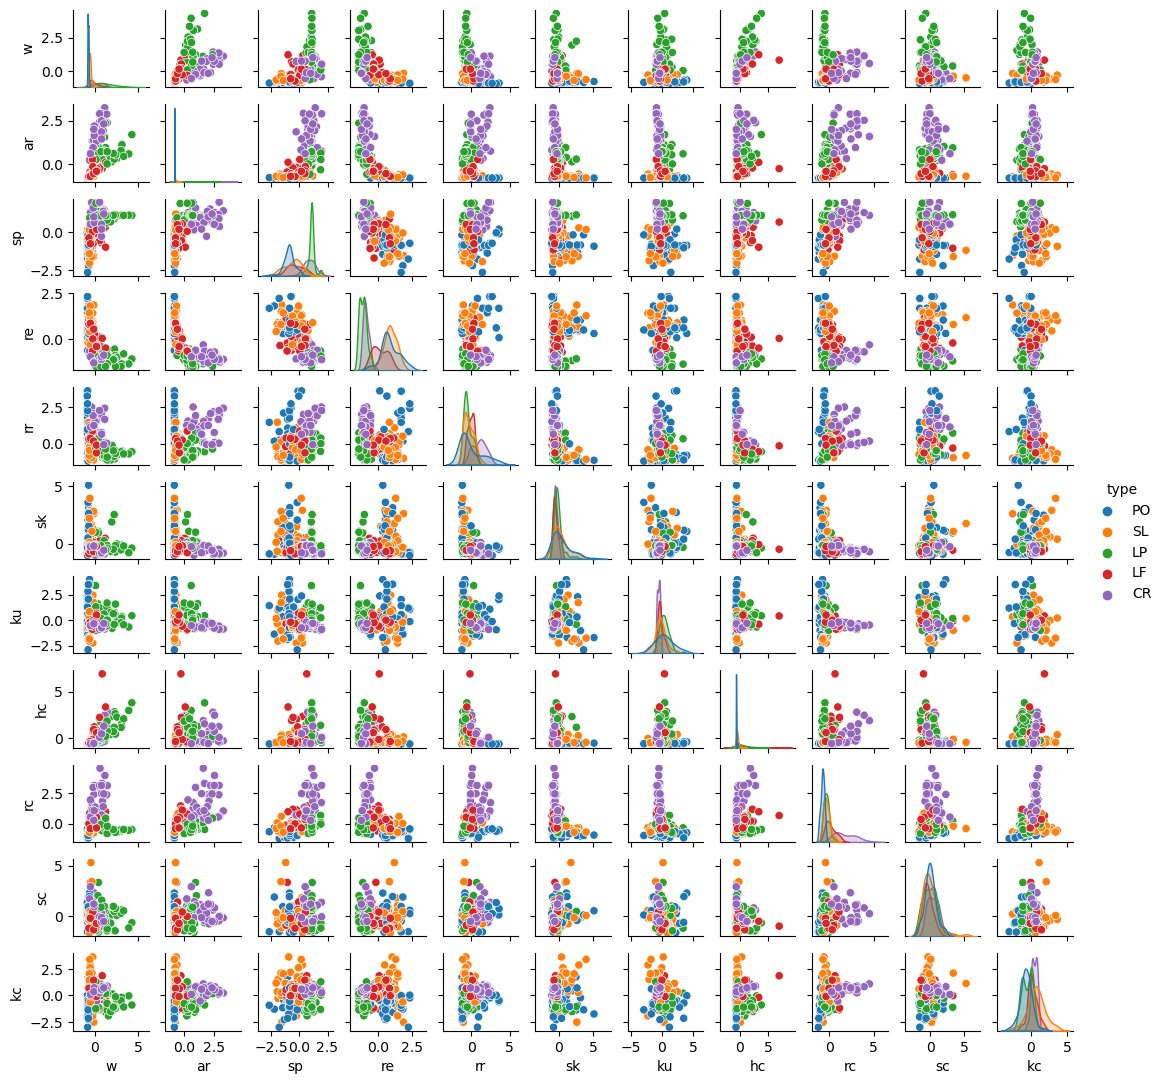

In [20]:
sns.pairplot(df, vars=nums, hue='type', diag_kind='kde', height=1)

<Axes: >

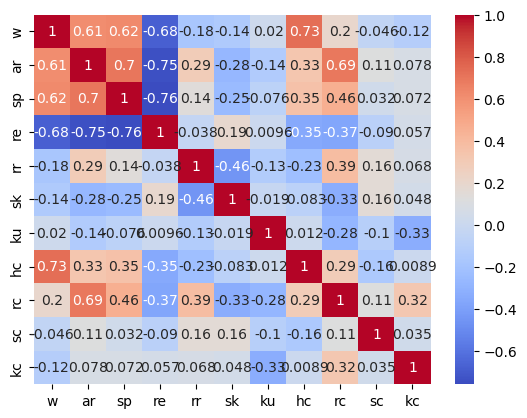

In [21]:
sns.heatmap(df[nums].corr(), annot=True, cmap='coolwarm')

# 2 &nbsp; `Train and Test Split`

We will begin by splitting our data into training and testing sets, using a 20% test size, and as stated at the beginning, we ill keep our data balanced about our target. This can be achieved simply with the `stratify` parameter in the `train_test_split()` function.

In [23]:
X = df.select_dtypes(include=['float64']).values
Y = df.select_dtypes(include=['uint8']).values
y = df['type'].values
y = LabelEncoder().fit_transform(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

print(f'X_train shape: {X_train.shape} Type: {type(X_train)}')
print(f'X_test  shape: {X_test.shape}  Type: {type(X_test)}')
print(f'y_train shape: {Y_train.shape}  Type: {type(Y_train)}')
print(f'y_test  shape: {Y_test.shape}   Type: {type(Y_test)}')

n_features = X.shape[1]
n_classes = Y.shape[1]
print('number of features: ', n_features)
print('number of classes : ', n_classes)

X_train shape: (175, 11) Type: <class 'numpy.ndarray'>
X_test  shape: (44, 11)  Type: <class 'numpy.ndarray'>
y_train shape: (175, 5)  Type: <class 'numpy.ndarray'>
y_test  shape: (44, 5)   Type: <class 'numpy.ndarray'>
number of features:  11
number of classes :  5


# 3 &nbsp; `Model Replication`

Model architecture will begin by replicating the model type from the paper in a general format. Only after will we explore different architecture.  

The only hard coded parameters will be:
- the hidden layers activation function of Rectified Linear Unit (ReLU)
- an output activaiton funciton of Sigmoid (Softmax)
- a weight/kernel initalizer of random normal
- categorical_crossentropy loss function
- accuracy metric

These activaiton functions are typically reguarded as the best for a classification task such as this. Relu generally does the best at solving the vanishing gradient problem, just as the paper states, and softmax enables the decisive classificaiton to work as it results in probabilities in each output node / weld defect type. Alternative activations and initalizers will not be explored.

All other parameters can be adjusted when calling the model function `unified_DNN()`. This includes: 
- the number of layers
- number of nodes per layer
- optimizer
- learning rate
- regularization factor

Note that the `hidden_nodes` parameter is a list of a list of integers. Each list represents a hidden layer, and each interger in the list represents the number of nodes in that layer, and the reduced node amount for the skip to the final hidden layer, respectively. In this way, if we have 3 lists we will have 4 hidden layers. The first 3 all have their outputs sent to the layer in front of them, as well as to the final hidden layer. To understand this visually, see the images below the following code block.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 6)            72          ['input_2[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 5)            35          ['dense_7[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 5)            30          ['dense_9[0][0]']                
                                                                                            

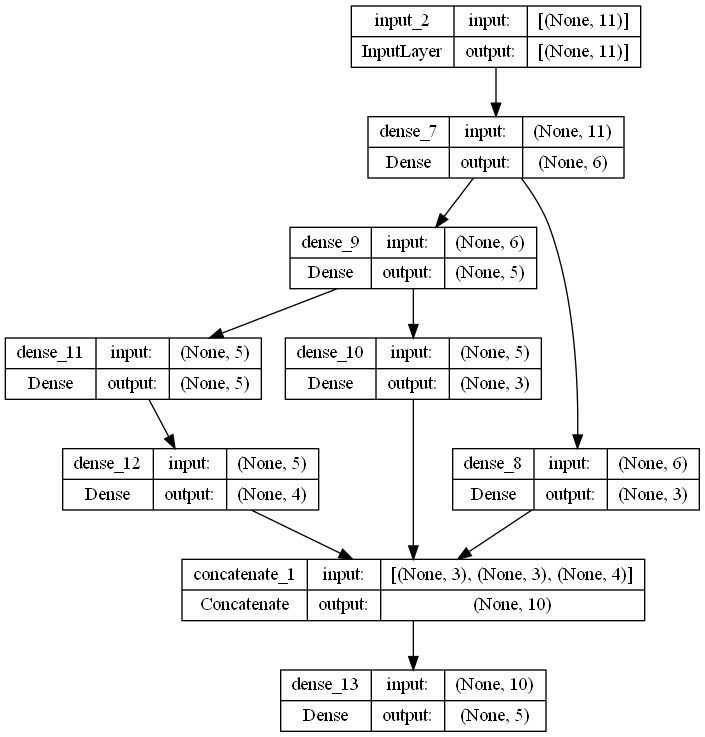

In [25]:
def unified_DNN(input_dim=11, output_dim=5, hidden_nodes=[[6, 3], [5, 3], [5, 4]], 
                optimizer='adam', learning_rate=0.001, regularization_factor=0.01):
    '''
    How to call:
    model_name = unified_DNN(input_dim=n_features, output_dim=n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]], 
                             optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
    '''

    # input layer
    inputs = Input(shape=(input_dim,))

    # lists to hold hidden layers
    hidden_layers = []
    compressed_layers = []

    # create hidden layers
    for i in range(len(hidden_nodes)):
        if i == 0:
            # if it's the first hidden layer, connect it to the inputs
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(inputs))
        else:
            # otherwise, connect it to the previous hidden layer
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))
        
        # add compression layer
        compressed_layers.append(Dense(units=hidden_nodes[i][1], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))

    # concatenate the compressed layers
    concatenated = concatenate(compressed_layers)

    # output layer, directly connected to the concatenated layer
    outputs = Dense(output_dim, activation='softmax')(concatenated)

    # create model
    model = Model(inputs=inputs, outputs=outputs)

    # define optimizer with the given learning rate
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

    return model

model = unified_DNN(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]],
                           optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
model.summary()
plot_model(model, show_shapes=True)

Color coded to show resembelance to the paper's architecture:

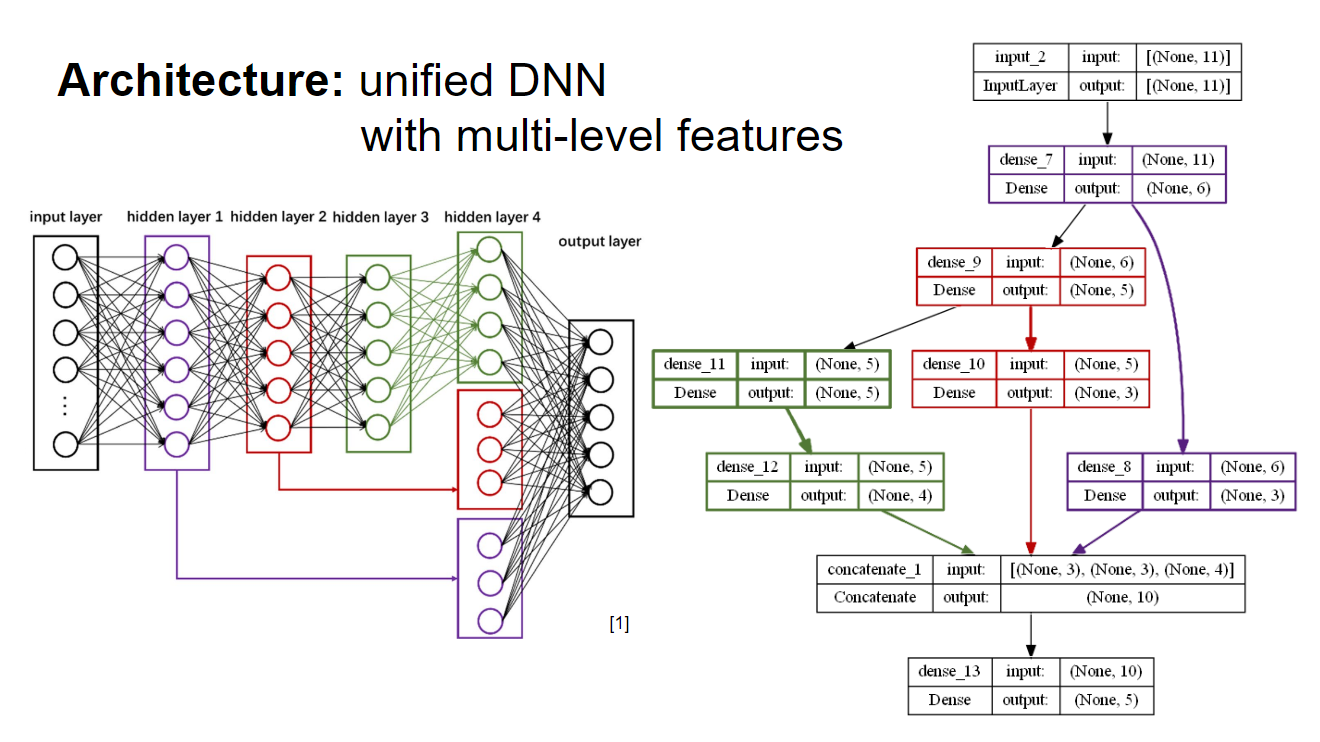

In [11]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store evaluation results across folds
# accuracy_scores_train = []
# accuracy_scores_test = []

# for train_index, test_index in kf.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     Y_train, Y_test = Y[train_index], Y[test_index]
    
#     # Define early stopping callback
#     early_stop = EarlyStopping(monitor='val_loss', patience=100)
#     # Train the model
#     model_fit = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])
    
#     # Test your model's performance on the training and test sets
#     Y_pred_train = model.predict(X_train)
#     Y_pred_test = model.predict(X_test)
    
#     # Convert the prediction probabilities into class predictions
#     y_pred_train = (Y_pred_train > 0.5).astype(int)
#     y_pred_test = (Y_pred_test > 0.5).astype(int)
    
#     # Evaluate the model's performance on the testing set
#     # accuracy_score doesn't work with multilabel output, you need to use some other metric
#     # One possibility is average accuracy per class
#     accuracy_train = np.mean([accuracy_score(Y_train[:, i], y_pred_train[:, i]) for i in range(Y_train.shape[1])])
#     accuracy_test = np.mean([accuracy_score(Y_test[:, i], y_pred_test[:, i]) for i in range(Y_test.shape[1])])
#     accuracy_scores_train.append(accuracy_train)
#     accuracy_scores_test.append(accuracy_test)
    
# # Aggregate the evaluation results across folds
# mean_accuracy_train = np.mean(accuracy_scores_train)
# mean_accuracy_test = np.mean(accuracy_scores_test)
# print(f'Mean training accuracy over {kf.n_splits} folds: {mean_accuracy_train:.6f}')
# print(f'Mean testing accuracy over {kf.n_splits} folds: {mean_accuracy_test:.6f}')

In [12]:
model_prod = unified_DNN(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]],
                                optimizer='adam', learning_rate=0.001, regularization_factor=0.01)

# Define early stopping callback
early_stop_prod = EarlyStopping(monitor='val_loss', patience=100)
# Train the model
model_prod_fit = model_prod.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop_prod])

Epoch 1/1000
175/175 [==============================] - 2s 5ms/step - loss: 1.6090 - accuracy: 0.2743 - val_loss: 1.6032 - val_accuracy: 0.3636
Epoch 2/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.5956 - accuracy: 0.3657 - val_loss: 1.5807 - val_accuracy: 0.3636
Epoch 3/1000
175/175 [==============================] - 1s 3ms/step - loss: 1.5582 - accuracy: 0.3257 - val_loss: 1.5283 - val_accuracy: 0.3864
Epoch 4/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.4938 - accuracy: 0.3657 - val_loss: 1.4633 - val_accuracy: 0.3409
Epoch 5/1000
175/175 [==============================] - 1s 3ms/step - loss: 1.4286 - accuracy: 0.4343 - val_loss: 1.4041 - val_accuracy: 0.4318
Epoch 6/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.3688 - accuracy: 0.4743 - val_loss: 1.3424 - val_accuracy: 0.4318
Epoch 7/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.2955 - accuracy: 0.4514 - val_loss: 1.2529 - val_accuracy:

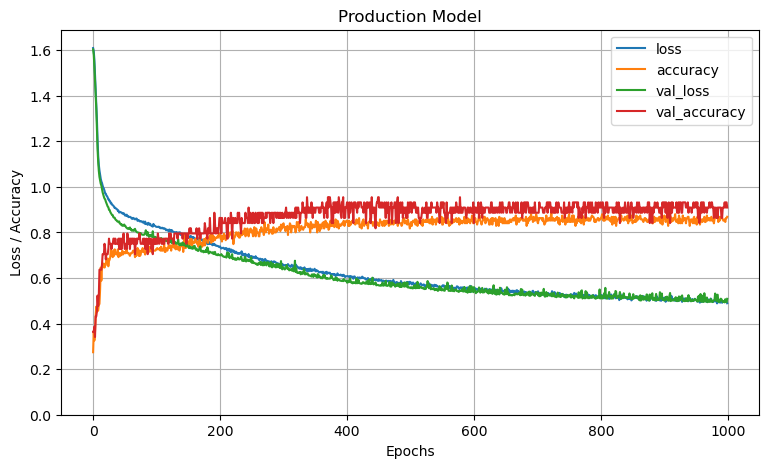

In [13]:
maxes = []
for met in model_prod_fit.history.keys():
    maxes.append(max(model_prod_fit.history[met]))
mmax = max(maxes)

pd.DataFrame(model_prod_fit.history).plot(figsize=(9, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.05*mmax)
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Production Model')
plt.show()

In [14]:
# # learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
# # regularization_factors = [0.3, 0.25, 0.2, 0.15, 0.1, 0.5, 0.01, 0.05, 0.001, 0.0005]
# learning_rates = [0.0005, 0.001, 0.005 ,0.01, 0.02]
# regularization_factors = [0.05, 0.01, 0.05, 0.001, 0.0005, 0.0001]
# # Initialize dictionary to hold results
# results = {}

# for lr in learning_rates:
#     for rf in regularization_factors:
#         # Create and train the model
#         model = unified_DNN(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]], 
#                                    optimizer='adam', learning_rate=lr, regularization_factor=rf)
#         early_stop = EarlyStopping(monitor='val_loss', patience=50)
#         history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])

#         # Store the results
#         results[(lr, rf)] = {
#             'accuracy': max(history.history['accuracy']),
#             'loss': min(history.history['loss']),
#             'val_accuracy': max(history.history['val_accuracy']),
#             'val_loss': min(history.history['val_loss'])
#         }


In [15]:
# import seaborn as sns

# # Reshape accuracy results into a matrix
# accuracy_results = np.zeros((len(learning_rates), len(regularization_factors)))
# for i, lr in enumerate(learning_rates):
#     for j, rf in enumerate(regularization_factors):
#         accuracy_results[i, j] = results[(lr, rf)]['accuracy']

# # Create a heatmap
# plt.figure(figsize=(10, 4))
# sns.heatmap(accuracy_results, annot=True, fmt=".4f", xticklabels=regularization_factors, yticklabels=learning_rates)
# plt.title('Accuracy')
# plt.xlabel('Regularization Factor')
# plt.ylabel('Learning Rate')
# plt.show()


In [16]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracy_scores_train = []
# accuracy_scores_test = []

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     Y_train, Y_test = Y[train_index], Y[test_index]
    
#     # Define early stopping callback
#     early_stop = EarlyStopping(monitor='val_loss', patience=100)
#     # Train the model
#     model_fit = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])
    
#     # Test your model on the testing set
#     Y_pred_train = model.predict(X_train)
#     Y_pred_test = model.predict(X_test)
    
#     # Convert the prediction probabilities into class predictions
#     Y_pred_train = (Y_pred_train > 0.5).astype(int)
#     Y_pred_test = (Y_pred_test > 0.5).astype(int)
    
    
#     # Evaluate the model's performance on training and testing set
#     accuracy_train = np.mean([accuracy_score(Y_train[:, i], Y_pred_train[:, i]) for i in range(Y_train.shape[1])])
#     accuracy_test = np.mean([accuracy_score(Y_test[:, i], Y_pred_test[:, i]) for i in range(Y_test.shape[1])])
#     accuracy_scores_train.append(accuracy_train)
#     accuracy_scores_test.append(accuracy_test)
    
# # Aggregate the evaluation results across folds
# mean_accuracy_train = np.mean(accuracy_scores_train)
# mean_accuracy_test = np.mean(accuracy_scores_test)
# print(f'Mean training accuracy over {skf.n_splits} folds: {mean_accuracy_train:.6f}')
# print(f'Mean testing accuracy over {skf.n_splits} folds: {mean_accuracy_test:.6f}')

2/2 [==============================] - 0s 3ms/step


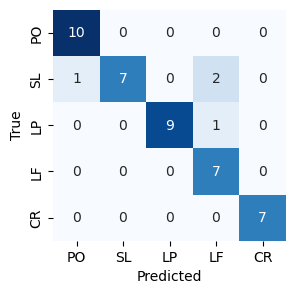

In [22]:


# # get predictions
# y_pred = grid.predict(X_test)

# # get accuracy
# acc = accuracy_score(Y_test, y_pred)

# # print accuracy
# print('Accuracy:', acc)

# # print best parameters
# print('Best Parameters:', grid.best_params_)


from sklearn.metrics import confusion_matrix

# predict classes for test set
Y_pred = model_prod.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# convert one-hot encoded test labels back to class labels
y_true = np.argmax(Y_test, axis=1)

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=types, yticklabels=types)
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.title('Confusion Matrix - Testing Set')
plt.show()

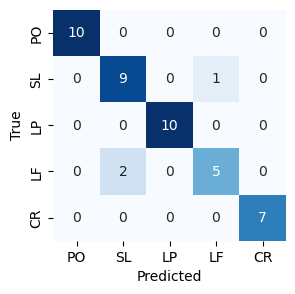

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Specify the labels for the axes
labels = types

# Specify the values for the confusion matrix
confusion_matrix = np.array([
    [10, 0, 0, 0, 0],
    [0, 9, 0, 1, 0],
    [0, 0, 10, 0, 0],
    [0, 2, 0, 5, 0],
    [0, 0, 0, 0, 7]
])

plt.figure(figsize=(3, 3))

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)

# plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [23]:
from sklearn.metrics import classification_report

# print classification report
print(classification_report(y_true, y_pred, target_names=types))

              precision    recall  f1-score   support

          PO       0.91      1.00      0.95        10
          SL       1.00      0.70      0.82        10
          LP       1.00      0.90      0.95        10
          LF       0.70      1.00      0.82         7
          CR       1.00      1.00      1.00         7

    accuracy                           0.91        44
   macro avg       0.92      0.92      0.91        44
weighted avg       0.93      0.91      0.91        44



# 5 &nbsp; `References`

[1] L. Yang and H. Jiang, “Weld defect classification in radiographic images using unified deep neural network with multi-level features,” *Journal of Intelligent Manufacturing*, vol. 32, no. 2, pp. 459–469, 2020. doi:10.1007/s10845-020-01581-2 

[2] D. Fafalis, “Project Spring 2023,” *MEM T380 – Applied Machine Learning in Mechanical Engineering*

In [20]:
end_time = time.time()
print(f'Total runtime of this notebook is {(end_time-start_time)/60:0.2f} minutes.')

Total runtime of this notebook is 8.18 minutes.
